In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np 
import scipy.sparse as sp
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings("ignore")

### Load data

In [2]:
def load_adj_and_features(threshold):

    feature_file = pd.read_csv('./data/BaselTMA_SP41_83_X14Y2.csv')
    proteins_all = list(feature_file.columns)[3:]
    cell_list = list(feature_file.iloc[:,0])
    location_x = np.array(feature_file['X']).reshape(-1,1)
    location_y = -np.array(feature_file['Y']).reshape(-1,1)
    features = feature_file.iloc[:,3:].values
    location = np.concatenate((location_x, location_y),axis=1)
    cell_distance = cdist(location,location, 'euclid')
    Min = np.min(cell_distance)
    Max = np.max(cell_distance)
    cell_distance = (cell_distance - Min) / (Max - Min)
    adj_threshold = np.where(cell_distance<threshold,1,0)

    return location, cell_list,features,proteins_all,adj_threshold


In [3]:
location, cell_list,features,proteins_all,adj_threshold = load_adj_and_features(0.03)

### Cluser

In [4]:
z_learned = np.load('./data/z_83_X14Y2.npy')
adata_learned = ad.AnnData(z_learned)
sc.pp.neighbors(adata_learned, n_neighbors=15,use_rep='X')
sc.tl.leiden(adata_learned,resolution = 0.6,key_added = "leiden_label") 
label = np.array(adata_learned.obs['leiden_label'])

In [5]:
adata_learned.obs['leiden_label']

0       7
1       7
2       7
3       7
4       7
       ..
2037    1
2038    1
2039    1
2040    8
2041    8
Name: leiden_label, Length: 2042, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

In [6]:
def shd_score(adj,label):
    np.fill_diagonal(adj,0)
    label_consistent_num = 0
    for i in range(adj.shape[0]):
        label_ = np.where(label==label[i],1,0)
        sum_ = adj[i,:]*label_
        label_consistent_num += sum_.sum()
    print(adj.sum())
    print(label_consistent_num)
    return label_consistent_num/adj.sum()

print('shd score:')
print(shd_score(adj_threshold,label))

shd score:
46834
23444
0.5005765042490499


### UMAP plot showing spatial location and cluster

In [7]:
adata_learned.obsm['location'] = location

In [8]:
adata_learned

AnnData object with n_obs × n_vars = 2042 × 32
    obs: 'leiden_label'
    uns: 'neighbors', 'leiden'
    obsm: 'location'
    obsp: 'distances', 'connectivities'

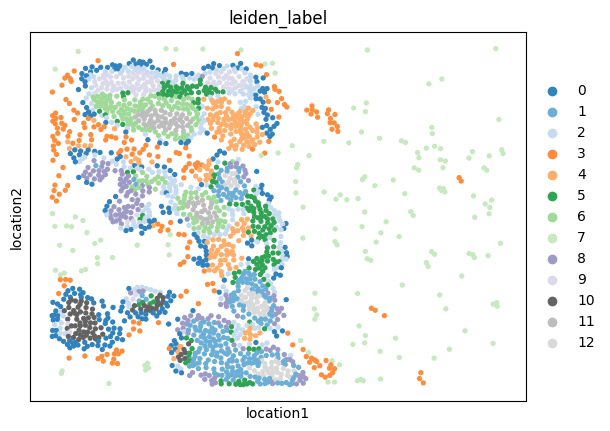

In [9]:
sc.pl.embedding(adata_learned, basis="location", color="leiden_label",palette='tab20c')